In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import cv2 
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
files = 0
images = 0
annotations = 0

for num, (dirname, _, filenames,) in enumerate(os.walk('/kaggle/input')):
    for file, filename in enumerate(filenames):
        if file==2:
            print(dirname, "  ... many on this folder")
        if filename.endswith(("xlsx", "txt", "csv")):
            files+=1
            print(os.path.join(dirname, filename))
        elif filename.endswith(("png", "jpeg", "jpg",)):
            images+=1
        else:
            annotations+=1
print("...\n")
print("#"*10, "        files: {} images: {} annotations: {}".format(files, images, annotations))

/kaggle/input/sartorius-cell-instance-segmentation/sample_submission.csv
/kaggle/input/sartorius-cell-instance-segmentation/train.csv
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y   ... many on this folder
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/skov3   ... many on this folder
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/bv2   ... many on this folder
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/bt474   ... many on this folder
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/a172   ... many on this folder
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/huh7   ... many on this folder
/kaggle/input/sartorius-cell-instan

In [3]:
# Original unet taken from https://www.kaggle.com/stpeteishii/cell-instance-segmentation-unet

 # data understanding

In [4]:
# read data first. The csv is the core.
train_data = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
print(train_data.shape)
train_data.head(3)

(73585, 9)


,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [5]:
# submision sample
sample_submission=pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(3, 2)


,id,predicted
0,7ae19de7bc2a,NaN
1,d48ec7815252,NaN
2,d8bfd1dafdc4,NaN


In [6]:
# we will focus on the train folder, as it contains the images to process. The others not for now.
print("Number of images in the folder train:")
len(os.listdir('../input/sartorius-cell-instance-segmentation/train'))

Number of images in the folder train:


606

In [7]:
print("Number of unique id on the file:")
train_data.id.unique().shape

Number of unique id on the file:


(606,)

The id column contains all the train images codes. But each id column is repetead an have several notations. Each of the have diferent counts

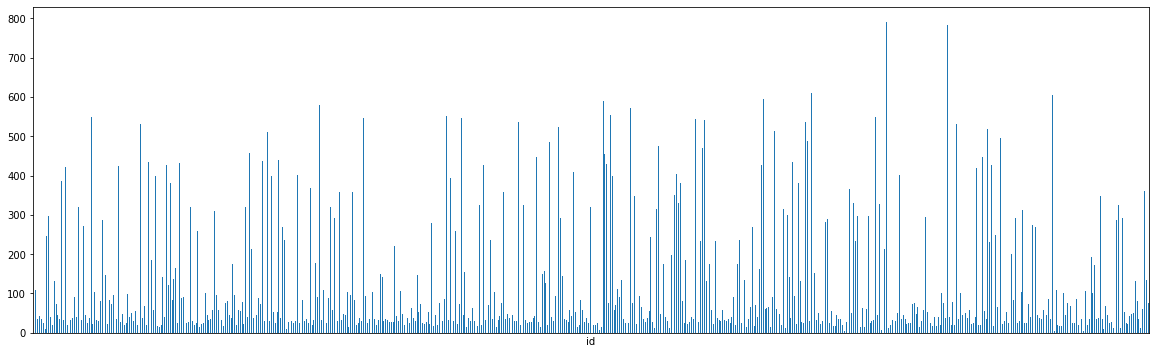

In [8]:
plt.figure(figsize=(20,6))
train_data.groupby("id").size().plot.bar();
plt.xticks([])
plt.show()

In [9]:
print(train_data[train_data["id"]=="0030fd0e6378"]["id"].count())
print(train_data[train_data["id"]=="0140b3c8f445"]["id"].count())

395
108


In [10]:
# other columns
train_data.sample_id.unique().shape

(403,)

In [11]:
train_data[train_data["id"]=="0030fd0e6378"]["sample_id"].unique()

array(['shsy5y[diff]_E10-4_Vessel-714_Ph_3'], dtype=object)

In [12]:
# sample_id is bounded to the id
train_data.groupby(["id", "sample_id"]).size().count()

606

In [13]:
#checking for missing values. None
train_data.isnull().sum().sum()

0

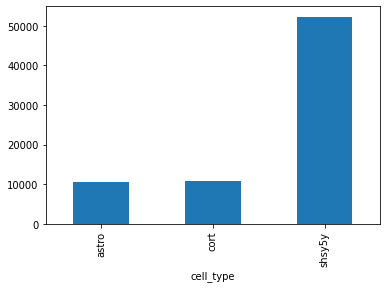

In [14]:
import matplotlib.pyplot as plt
train_data.groupby('cell_type').size().plot.bar()
plt.show()

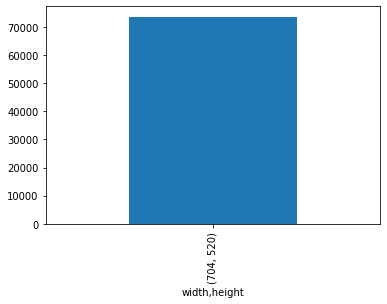

In [15]:
import matplotlib.pyplot as plt
train_data.groupby(['width', 'height']).size().plot.bar()
plt.show()

Summary of the columns:
    - id: name of the train picture
    - annotation: info of the target mask of the neuron cells
    - width, heigh: width and heigh of the images (constant of 704x520)
    - plate_time: not usefull
    - sample_date: not usefull
    - sample_id
    - Elapsed_timedelta: not usefull

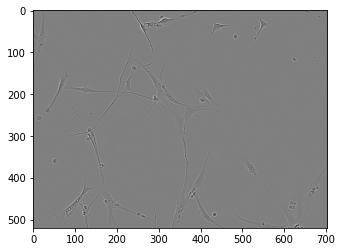

In [16]:
# check the images
img = cv2.imread("../input/sartorius-cell-instance-segmentation/train_semi_supervised/astro[hippo]_D1-1_Vessel-361_2020-09-14_13h00m00s_Ph_1.png")
plt.imshow(img);

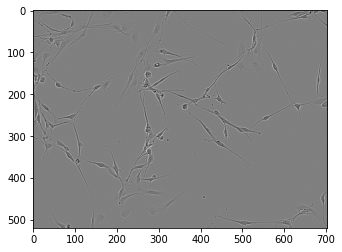

In [17]:
img = cv2.imread("../input/sartorius-cell-instance-segmentation/train/0140b3c8f445.png")
plt.imshow(img);

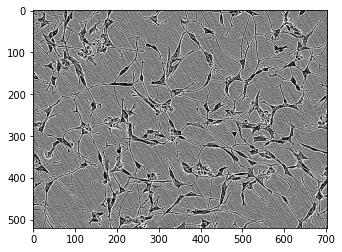

In [18]:
# add the filters to see it better
from PIL import Image, ImageEnhance
img = cv2.imread("../input/sartorius-cell-instance-segmentation/train/042c17cd9143.png")
img = np.asarray(ImageEnhance.Contrast(Image.fromarray(img)).enhance(16))

plt.figure()
plt.imshow(img);

In [19]:
# sooo an image id has several anotations... but there are multiple id's repetitions with the same sample_id...
train_data[train_data["id"]=="0030fd0e6378"]

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
390,0030fd0e6378,264628 3 265328 8 266028 12 266729 15 267432 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
391,0030fd0e6378,268853 4 269553 10 270255 12 270958 12 271661 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
392,0030fd0e6378,2095 1 2798 3 3501 5 4203 7 4906 9 5609 10 631...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
393,0030fd0e6378,105571 3 106274 5 106978 5 107682 6 108386 6 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [20]:
# how to process annotations.

# read one annotation
mask_rle = train_data[train_data["id"] == "0030fd0e6378"]["annotation"].tolist()[0]
shape=(520, 704, 3)
s = mask_rle.split()

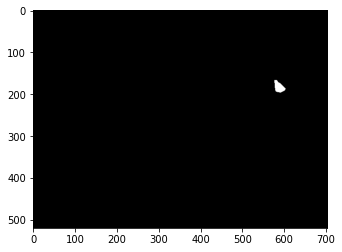

In [21]:
starts = list(map(lambda x: int(x) - 1, s[0::2])) # get the starting coordinate (on the even positions)
lengths = list(map(int, s[1::2])) # get the lenght (on the not even positions)
ends = [x + y for x, y in zip(starts, lengths)] # calculate the end point (starting point + lenght)

# create a blank inage
img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

# fill the positions on the image with a color to create the mask
for start, end in zip(starts, ends):
    img[start : end] = 1

plt.figure()  
plt.imshow(img.reshape(shape));

In [22]:
len(train_data[train_data["id"] == "0030fd0e6378"]["annotation"].tolist())

395

In [23]:
# Reference: https://www.kaggle.com/ihelon/cell-segmentation-run-length-decoding
#https://www.kaggle.com/susnato/understanding-run-length-encoding-and-decoding?scriptVersionId=77552323
# coding packed into one function

def rle_decode(mask_rle, shape, color=3):     #color=1,3
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return 
    color: color for the mask
    Returns numpy array (mask)
    '''
    s = mask_rle.split()
    
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
            
    for start, end in zip(starts, ends):
        img[start : end] = color
    
    return img.reshape(shape)

In [24]:
# other version
# https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/291627
def rle_decode(mask_rle, shape=(520, 704, 1)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

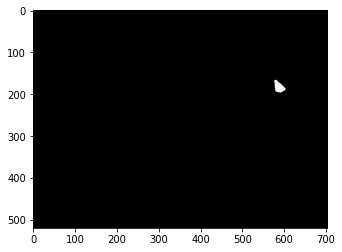

In [25]:
# each mask annotation has one area
mask = train_data[train_data["id"] == "0030fd0e6378"]["annotation"].tolist()[0]
img = rle_decode(mask)
plt.imshow(img, cmap="gray");

In [26]:
mask

'118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4'

In [27]:
img.shape

(520, 704, 1)

In [28]:
rle_encode(img)

'118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4'

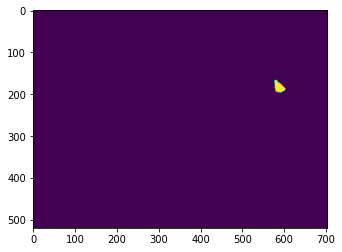

In [29]:
# revert the encodig has a correct recosntruction?
plt.imshow(rle_decode(rle_encode(img)));

# data processing

In [30]:
def plot_masks(image_id, colors=False):
    labels = train_data[train_data["id"] == image_id]["annotation"].tolist()

    if colors:
        mask = np.zeros((520, 704, 3))
        for label in labels:
            mask += rle_decode(label, shape=(520, 704, 3), color=np.random.rand(3))
    else:
        mask = np.zeros((520, 704, 1))
        for label in labels:
            mask += rle_decode(label, shape=(520, 704, 1))
    mask = mask.clip(0, 1)

    image = cv2.imread(f"../input/sartorius-cell-instance-segmentation/train/{image_id}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(18,6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Input image')
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.1)
    plt.title('Input image with mask')
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask)
    plt.title('Only mask')
    plt.axis("off")
    
    plt.show();

ID: 0030fd0e6378 , CellType: shsy5y


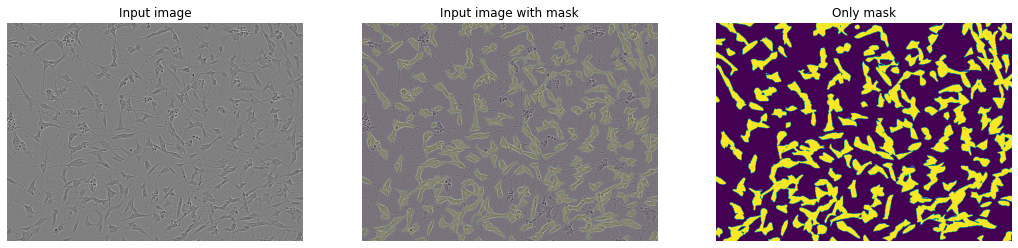

ID: 0140b3c8f445 , CellType: astro


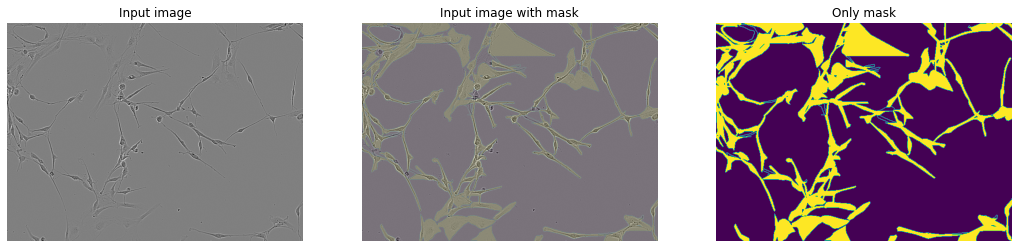

ID: 01ae5a43a2ab , CellType: cort


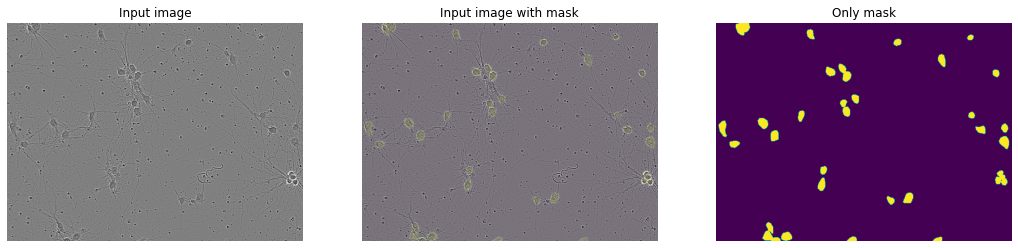

In [31]:
sample_ids = ['0030fd0e6378','0140b3c8f445','01ae5a43a2ab']

for sample_id in sample_ids:
    celltype=train_data[train_data['id']==sample_id]['cell_type'].tolist()[0]
    file_path = '../input/sartorius-cell-instance-segmentation/train/' + sample_id + '.png'
    image_df = cv2.imread(file_path)
    print('ID:', sample_id, ', CellType:',celltype)
    plot_masks(sample_id, colors=False)

In [32]:
# Reference: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../input/sartorius-cell-instance-segmentation/train/'

train_ids = train_data['id'].unique().tolist()
test_ids = sample_submission['id'].unique().tolist()

# Get and resize train images and masks
X_train = np.zeros((train_data['id'].nunique(), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((train_data['id'].nunique(), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [33]:
from tqdm import tqdm
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = cv2.imread(path + '.png')[:,:]
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_LINEAR)
    #img = np.expand_dims(img, axis = 2)
    X_train[n] = img
    
    labels = train_data[train_data["id"] == id_]["annotation"].tolist()
    mask = np.zeros((520, 704, 1))
    for label in labels:
        mask += rle_decode(label, shape=(520, 704, 1))
    mask = mask.clip(0, 1)
    mask = mask[:,:,0]

    mask = np.expand_dims(cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_LINEAR), axis=-1)
    
    Y_train[n] = mask
print("Done")

100%|██████████| 606/606 [00:41<00:00, 14.45it/s]

Done


In [34]:
# Get and resize test images
X_test = np.zeros((sample_submission['id'].nunique(), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_images_id = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TRAIN_PATH.replace('train', 'test') + id_
    img = cv2.imread(path + '.png')[:,:]
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_LINEAR)
    #img = np.expand_dims(img, axis = 2)
    X_test[n] = img
    test_images_id.append(id_)
print("Done")

100%|██████████| 3/3 [00:00<00:00, 66.60it/s]

Done


In [35]:
print(X_train.shape,Y_train.shape,X_test.shape)

(606, 256, 256, 3) (606, 256, 256, 1) (3, 256, 256, 3)


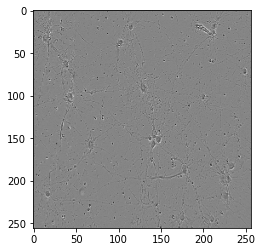

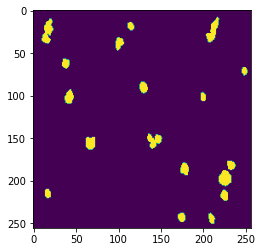

Input image: Min: 6 ; Max: 240 ; Mean: 127.80513000488281
Mask: Min: False ; Max: True ; Mean: 0.0323333740234375


In [36]:
sample_id_num = 40
plt.imshow(X_train[sample_id_num][:,:,0], cmap = 'gray')
plt.show()
plt.imshow(Y_train[sample_id_num][:,:,0])
plt.show()

print('Input image:','Min:', X_train[sample_id_num][:,:,0].min(), '; Max:', X_train[sample_id_num][:,:,0].max(), '; Mean:', X_train[sample_id_num][:,:,0].mean())
print('Mask:','Min:', Y_train[sample_id_num][:,:,0].min(), '; Max:', Y_train[sample_id_num][:,:,0].max(), '; Mean:', Y_train[sample_id_num][:,:,0].mean())

# modeling

In [37]:
#dice_coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [38]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
activation='elu'
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])
#model.summary()

2022-11-19 12:01:07.286637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 12:01:07.370509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 12:01:07.371318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 12:01:07.372483: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [39]:
# Fit model
earlystopper = EarlyStopping(patience=40, verbose=1)
#checkpointer = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

results = model.fit(X_train, Y_train, validation_split=0.12, batch_size=10, epochs=71, 
                    callbacks=[earlystopper])

2022-11-19 12:01:10.687411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/71


2022-11-19 12:01:13.375093: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


54/54 [==============================] - 13s 70ms/step - loss: 0.3921 - dice_coefficient: 0.1153 - val_loss: 0.3651 - val_dice_coefficient: 0.1396
Epoch 2/71
54/54 [==============================] - 3s 55ms/step - loss: 0.3751 - dice_coefficient: 0.1162 - val_loss: 0.3527 - val_dice_coefficient: 0.1305
Epoch 3/71
54/54 [==============================] - 3s 55ms/step - loss: 0.3768 - dice_coefficient: 0.1172 - val_loss: 0.3452 - val_dice_coefficient: 0.1048
Epoch 4/71
54/54 [==============================] - 3s 55ms/step - loss: 0.3696 - dice_coefficient: 0.1191 - val_loss: 0.3440 - val_dice_coefficient: 0.1109
Epoch 5/71
54/54 [==============================] - 3s 56ms/step - loss: 0.3693 - dice_coefficient: 0.1164 - val_loss: 0.3438 - val_dice_coefficient: 0.1086
Epoch 6/71
54/54 [==============================] - 3s 55ms/step - loss: 0.3678 - dice_coefficient: 0.1197 - val_loss: 0.3423 - val_dice_coefficient: 0.1210
Epoch 7/71
54/54 [==============================] - 3s 55ms/step - l

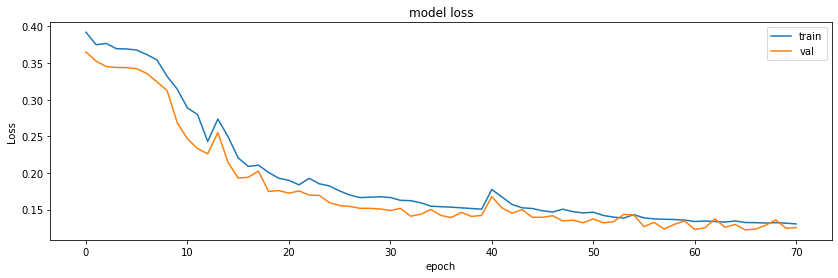

In [40]:
plt.figure(figsize=(14,4))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

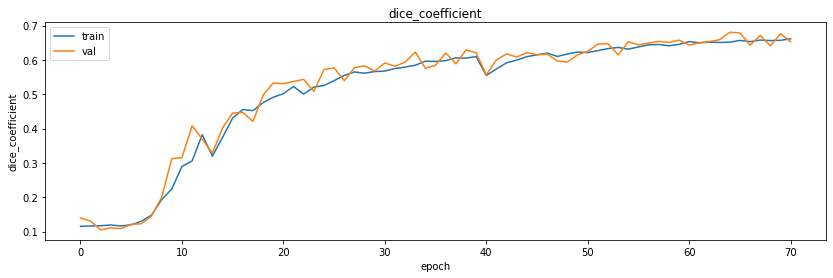

In [41]:
plt.figure(figsize=(14,4))
plt.plot(results.history['dice_coefficient'])
plt.plot(results.history['val_dice_coefficient'])
plt.title('dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
X_train.shape[0]*0.85

515.1

In [43]:
# Predict on train, val and test
#model = load_model('best_model.h5', custom_objects={'dice_coefficient': dice_coefficient})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.85)], verbose=1)
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 16ms/step


In [44]:
# by default I use threshold of 0.5. It is worth optimize it? In some notebooks the use it per class type. 
from statistics import mean
def get_threshold(Y, pred):
    scores = list(pred.ravel())
    mask = list(Y.ravel())
    
    idxs=np.argsort(scores)[::-1]
    mask_sorted=np.array(mask)[idxs]
    sum_mask_one=np.cumsum(mask_sorted)
    IoU=sum_mask_one/(np.arange(1,len(mask_sorted)+1)+np.sum(mask_sorted)-sum_mask_one)
    best_IoU_idx=IoU.argmax()
    best_threshold=scores[idxs[best_IoU_idx]]
    best_IoU=IoU[best_IoU_idx]

    return best_threshold, best_IoU


img_thresholds = []         # one for each image
img_IoUs = []
for Y, P in tqdm(zip(Y_train, preds_train), total=Y_train.shape[0]):

    best_img_threshold, best_img_IoU = get_threshold(Y, P)
    img_thresholds.append(best_img_threshold)
    img_IoUs.append(best_img_IoU)
    
best_threshold = np.mean(img_thresholds)
best_threshold_spread = np.std(img_thresholds)
avg_IoU = mean(img_IoUs)

print(f"Best threshold: {best_threshold:.3g} (+-{best_threshold_spread:.3g}), Avg. Train IoU: {avg_IoU:.3f}")

 85%|████████▍ | 515/606 [00:10<00:01, 46.90it/s]

Best threshold: 0.418 (+-0.149), Avg. Train IoU: 0.640


In [45]:
# Threshold predictions
default_threshold = False

if default_threshold:
    threshold=0.5
else:
    threshold=best_threshold


preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_test_t = (preds_test > threshold).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(cv2.resize(np.squeeze(preds_test[i]), 
                                    (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA))

(-0.5, 255.5, 255.5, -0.5)

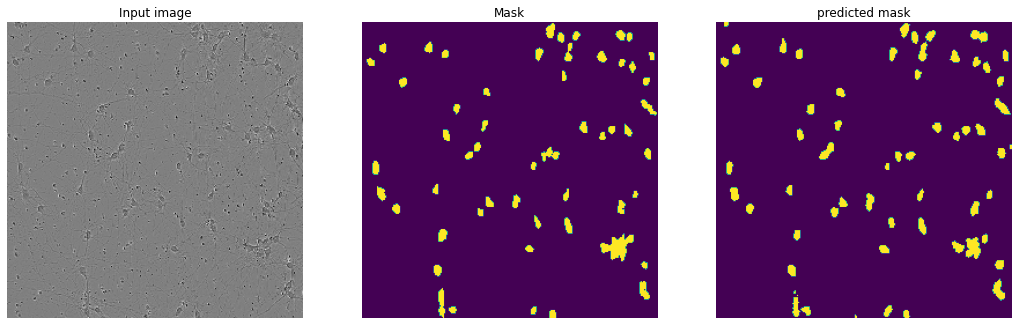

In [46]:
# Perform a sanity check on some random training samples
from random import randint
ix = randint(0, len(preds_train_t))
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(X_train[ix])
plt.title('Input image')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(Y_train[ix]))
plt.title('Mask')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.title('predicted mask')
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

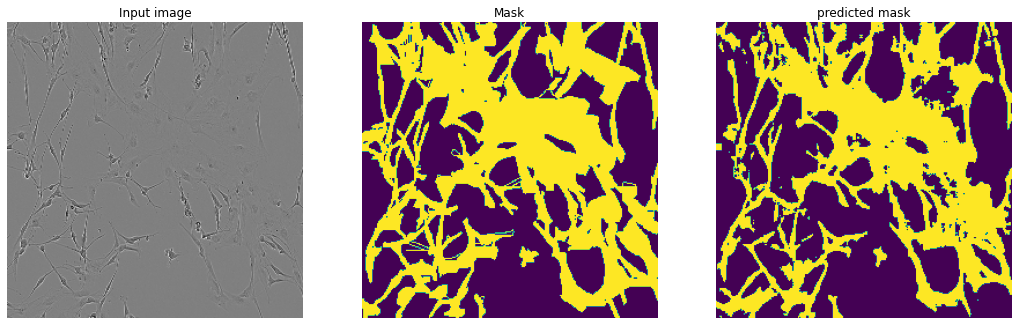

In [47]:
ix = randint(0, len(preds_train_t))
plt.figure(figsize=(18,6));
plt.subplot(1, 3, 1)
plt.imshow(X_train[ix])
plt.title('Input image')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(Y_train[ix]))
plt.title('Mask')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.title('predicted mask')
plt.axis("off")

In [48]:
#predictions not empty right?
print(np.count_nonzero(preds_train_t[ix]))

27930


In [49]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'gray', 'orange', 'green'])

def plot_colored(img_Y, img_pred):
    output = np.zeros_like(img_Y)
    output = np.where((img_Y == 0) & (img_pred == 1), 1, output)
    output = np.where((img_Y == 1) & (img_pred == 0), 2, output)
    output = np.where((img_Y == 1) & (img_pred == 1), 3, output)

    plt.figure(figsize=(10,10))
    plt.imshow(output, cmap=cmap)
    plt.xticks([])
    plt.yticks([]);

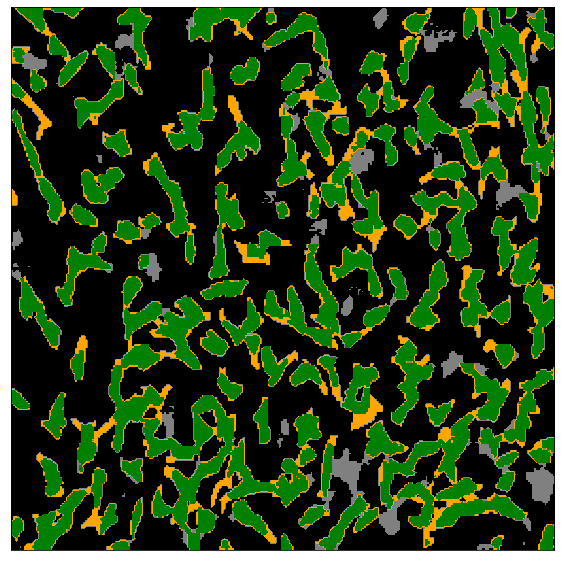

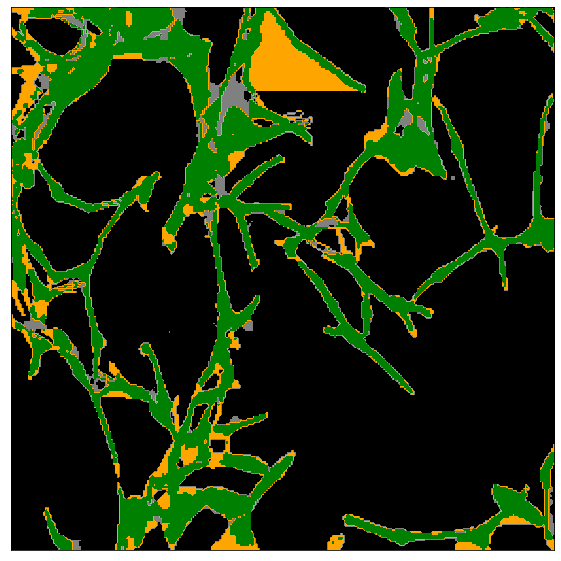

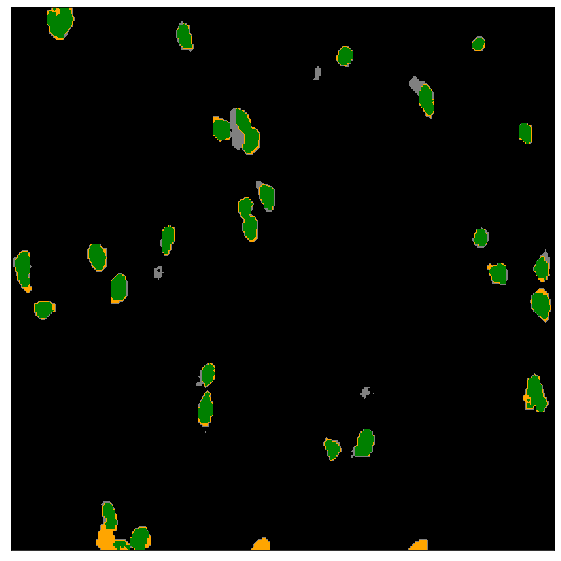

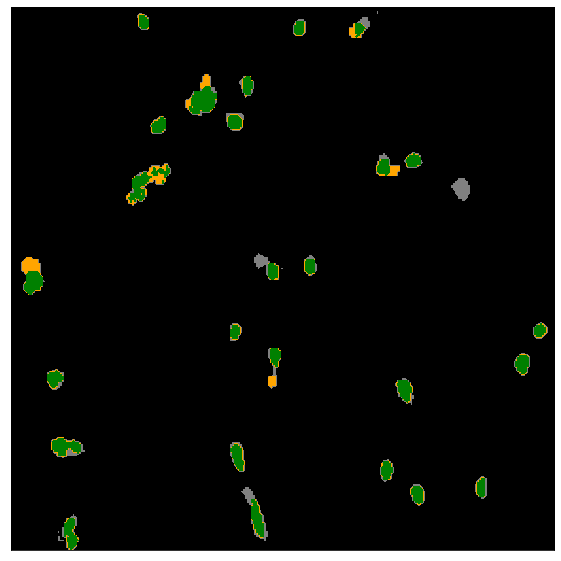

In [50]:
N = 4
for i in range(N):
    plot_colored(Y_train[i], preds_train_t[i])
    plt.show()
# green: correct prediction
# gray: false positive (too much)
# orange: false negative (missed)

# prepare the submision file

In [51]:
#test_mask: after reshape before fix_overlapping
test_masks = [cv2.resize(pred,dsize=(704,520),interpolation=cv2.INTER_CUBIC).reshape(520,704,1) for pred in preds_test_t]
print(test_masks[0].shape)
print(test_masks[1].shape)
print(test_masks[2].shape)

(520, 704, 1)
(520, 704, 1)
(520, 704, 1)


# fix_overlap
https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/279995

In [52]:
def check_overlap(msk):
    msk = msk.astype(np.bool).astype(np.uint8)
    return np.any(np.sum(msk, axis=-1)>1)

def fix_overlap(msk):
    """
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None)
    """
    msk = np.array(msk)
    msk = np.pad(msk, [[0,0],[0,0],[1,0]])
    ins_len = msk.shape[-1]
    msk = np.argmax(msk,axis=-1)
    msk = tf.keras.utils.to_categorical(msk, num_classes=ins_len)
    msk = msk[...,1:]
    msk = msk[...,np.any(msk, axis=(0,1))]
    return msk

def remove_isolated_points_from_rle(strin):
    t2 = strin.split(" ")
    a = []
    for i in range(0, len(t2), 2):
        if t2[i+1]!="1":
            a.append(t2[i])
            a.append(t2[i+1])
    return ' '.join(a)

In [53]:
for test_mask in test_masks:
    print(check_overlap(test_mask))

False
False
False


In [54]:
#test_mask2: after reshape after fix_overlapping. No need right now
#test_masks2=[]
#for test_mask in test_masks:
#    test_mask2 = fix_overlap(test_mask).reshape(520,704,1)
#    print(test_mask2.shape)
#    test_masks2+=[test_mask2]

#for test_mask2 in test_masks2:
 #   print(check_overlap(test_mask2))

In [55]:
# revert the output codes to the file

In [56]:
predicted2 = [rle_encode(test_mask2) for test_mask2 in test_masks]
#print(predicted2[0])

# split the mask into each cluster nucleus

In [57]:
# split the mask into each cluster nucleus for the submision
# seen on https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/288376
def post_process(mask, min_size=80, shape=(520, 704,)):
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = []
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            a_prediction = np.zeros(shape, np.float32)
            a_prediction[p] = 1
            predictions.append(a_prediction)
    return predictions

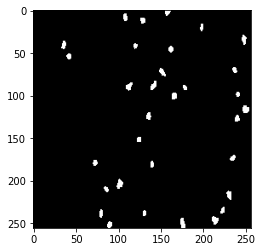

In [58]:
# test the nucleus thing. Take one simple mask
plt.imshow(Y_train[4], cmap="gray");

33


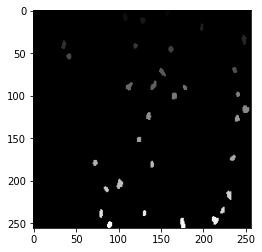

In [59]:
# connectedComponents returns the number of compenets of the image and a image with a pixel value of each of them
num_component, component = cv2.connectedComponents(Y_train[4].astype(np.uint8))
print(num_component)
plt.imshow(component, cmap="gray");

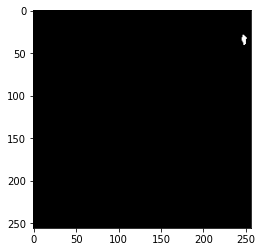

In [60]:
# extraction of the component of value 5 as example
compenent_5 = (component == 5)
plt.imshow(compenent_5, cmap="gray");

(256, 256)


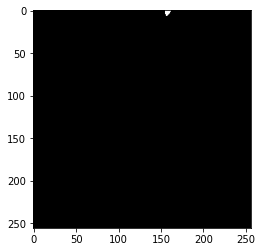

In [61]:
# all together
# notice that with the size of the training the min size also is affected. The minimun size on this case is 20
final = post_process(Y_train[4], min_size=20, shape=(IMG_HEIGHT, IMG_WIDTH,))
print(final[0].shape)
plt.imshow(final[0], cmap="gray");

# create submision file

In [62]:
preds_test_t[0].shape

(256, 256, 1)

In [63]:
# new version with the mask nucleus split
predicted_nucleus = []
test_nucleus_image_id = []

for index, s in enumerate(preds_test_t):
    nucleus = post_process(cv2.resize(s, (704,520,), interpolation = cv2.INTER_LINEAR))
    for nucl in nucleus:
        predicted_nucleus.append(nucl)
        test_nucleus_image_id.append(test_images_id[index])

(520, 704)

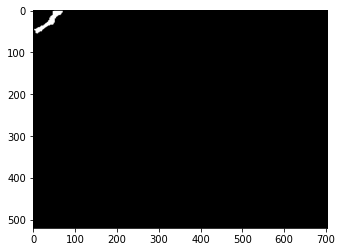

In [64]:
plt.imshow(predicted_nucleus[0], cmap="gray");
predicted_nucleus[0].shape

In [65]:
predicted2 = [rle_encode(test_mask2) for test_mask2 in predicted_nucleus]
print(predicted2[0])
predicted_filt = [remove_isolated_points_from_rle(s) for s in predicted2]
print(predicted_filt[0])

51 21 755 21 1456 24 2160 24 2864 24 3568 24 4272 22 4976 21 5680 21 6384 21 7088 19 7792 19 8494 16 9197 16 9899 16 10602 17 11307 13 12010 14 12712 16 13416 16 14120 13 14824 13 15528 13 16232 13 16934 15 17637 16 18341 16 19045 16 19747 18 20450 19 21153 18 21855 19 22558 21 23261 21 23964 21 24666 16 25370 15 26068 17 26772 16 27474 16 28177 16 28876 19 29580 18 30281 19 30985 19 31684 22 32388 21 33092 19 33797 18 34503 16 35207 15 35911 10 36615 10 37319 7 38023 7 38730 2 39434 1
51 21 755 21 1456 24 2160 24 2864 24 3568 24 4272 22 4976 21 5680 21 6384 21 7088 19 7792 19 8494 16 9197 16 9899 16 10602 17 11307 13 12010 14 12712 16 13416 16 14120 13 14824 13 15528 13 16232 13 16934 15 17637 16 18341 16 19045 16 19747 18 20450 19 21153 18 21855 19 22558 21 23261 21 23964 21 24666 16 25370 15 26068 17 26772 16 27474 16 28177 16 28876 19 29580 18 30281 19 30985 19 31684 22 32388 21 33092 19 33797 18 34503 16 35207 15 35911 10 36615 10 37319 7 38023 7 38730 2


In [66]:
submit = sample_submission.copy()
submit = pd.DataFrame({'id':test_nucleus_image_id, 'predicted':predicted_filt})
print(submit.shape)
submit.head()

(94, 2)


,id,predicted
0,7ae19de7bc2a,51 21 755 21 1456 24 2160 24 2864 24 3568 24 4...
1,7ae19de7bc2a,139 13 843 13 1547 15 2251 16 2955 15 3659 16 ...
2,7ae19de7bc2a,194 10 898 10 1597 15 2300 16 3009 14 3714 13 ...
3,7ae19de7bc2a,276 8 980 8 1685 12 2388 13 3094 17 3799 16 45...
4,7ae19de7bc2a,447 7 1151 7 1852 13 2556 13 3260 13 3964 13 4...


In [67]:
submit.to_csv('submission.csv', index=False)